In [1]:
'''
a test for gpflow_nn_ker
'''
import tensorflow as tf
import gpflow
import gpflow_nn_ker
import numpy as np

import matplotlib.pyplot as plt

In [2]:
'''
the step function example
'''
custom_config = gpflow.settings.get_settings()
custom_config.verbosity.optimisation_verb = True

step_func = lambda x: np.where(x>0, 1.0, 0.0)
noise_sigma = 0.01

#for training data
num_train = 100
training_data_x = np.random.randn(num_train, 1)
training_data_y = step_func(training_data_x) + noise_sigma * np.random.randn(num_train, 1)
# print(training_data_x.shape, training_data_y.shape)



In [3]:
#GPR with NN featured Kernel
m = gpflow.models.GPR(training_data_x, training_data_y, kern=gpflow_nn_ker.NNFeaturedSE(1, [1, 6, 2], tf.nn.sigmoid))
print('origin log-likelihood: ', m.compute_log_likelihood())
# print(m.read_trainables())
m.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)
print('opt log-likelihood: ', m.compute_log_likelihood())
# print(m.read_trainables())

/home/navigator/.local/lib/python3.5/site-packages/gpflow/densities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


origin log-likelihood:  -100.23042895564994
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -305.117243
  Number of iterations: 21
  Number of functions evaluations: 110
opt log-likelihood:  305.1172429517348


In [4]:
#GPR with ordinary SE kernel
m_baseline = gpflow.models.GPR(training_data_x, training_data_y, kern=gpflow.kernels.RBF(1))
print('origin log-likelihood: ', m_baseline.compute_log_likelihood())
# print(m.read_trainables())
m_baseline.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m_baseline)
print('opt log-likelihood: ', m_baseline.compute_log_likelihood())
# print(m.read_trainables())

origin log-likelihood:  -101.3339626699806
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -52.566403
  Number of iterations: 11
  Number of functions evaluations: 18
opt log-likelihood:  52.56640266861905


test average loglikelihood:  3.712429825995192
test average loglikelihood (baseline):  -753.6718885497286


<IPython.core.display.Javascript object>


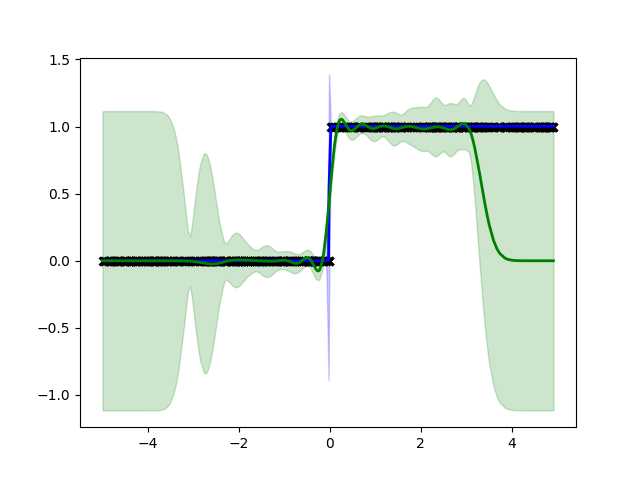

In [5]:
# for testing data
%matplotlib notebook
num_test = 500
test_data_x = np.random.rand(num_test, 1) * 10 - 5
test_data_x.sort(axis=0)
test_data_y = step_func(test_data_x)

pred_data_y_mean, pred_data_y_var = m.predict_f(test_data_x)
print('test average loglikelihood: ', np.mean(m.predict_density(test_data_x, pred_data_y_mean)))
pred_data_y_mean_baseline, pred_data_y_var_baseline = m_baseline.predict_f(test_data_x)
print('test average loglikelihood (baseline): ', np.mean(m.predict_density(test_data_x, pred_data_y_mean_baseline)))

#show the test data
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(test_data_x, test_data_y, 'kx', mew=2)

ax.plot(test_data_x, pred_data_y_mean, 'b', lw=2)
ax.fill_between(test_data_x[:,0], pred_data_y_mean[:,0] - 2*np.sqrt(pred_data_y_var[:,0]), pred_data_y_mean[:,0] + 2*np.sqrt(pred_data_y_var[:,0]), color='blue', alpha=0.2)

ax.plot(test_data_x, pred_data_y_mean_baseline, 'g', lw=2)
ax.fill_between(test_data_x[:,0], pred_data_y_mean_baseline[:,0] - 2*np.sqrt(pred_data_y_var_baseline[:,0]), pred_data_y_mean_baseline[:,0] + 2*np.sqrt(pred_data_y_var_baseline[:,0]), color='green', alpha=0.2)


# plt.show()

In [2]:
#lets try a 2D example for multiple output cases
#for multiple output, lets stick to conditional independence assumption, still trying to figure out more powerful coregionalization

#2-d path, three sections...
#first: straightline from [0, -1] to [-1, 0]
path_1 = lambda x: -x-1
x_1 = np.linspace(0, -1, 21)
y_1 = path_1(x_1)

#second: sinoid with a term of 2 and a phase shift
path_2 = lambda x: np.sin(np.pi*(x+1))
x_2 = np.linspace(-1, 1, 41)
y_2 = path_2(x_2)

#thirdly: straightline from [1, 0] to [0, 1]
path_3 = lambda x: -x+1
x_3 = np.linspace(1, 0, 21)
y_3 = path_3(x_3)

sect_1 = np.array([x_1, y_1]).T
sect_2 = np.array([x_2, y_2]).T
sect_3 = np.array([x_3, y_3]).T

#show them
# sect = np.vstack((sect_1, sect_2, sect_3))
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(sect[:, 0], sect[:, 1])



#find displacement within each section
disp_1 = sect_1[1:, :] - sect_1[:-1, :]
disp_2 = sect_2[1:, :] - sect_2[:-1, :]
disp_3 = sect_3[1:, :] - sect_3[:-1, :]

full_data_x = np.vstack((sect_1[:-1, :], sect_2[:-1,:], sect_3[:-1, :]))
full_data_y = np.vstack((disp_1, disp_2, disp_3))# note this is multidim now

full_sect = full_data_x.copy()
full_sect_dir = full_data_y.copy()

full_data_x += np.random.randn(*full_data_x.shape)*0.01
full_data_y += np.random.randn(*full_data_y.shape)*0.01
# print(full_data_x.shape, full_data_y.shape)


#prepare training and testing dataset
rand_indices = np.random.permutation(np.array(range(full_data_x.shape[0])))
training_indices = rand_indices[:60]
testing_indices = rand_indices[60:]

training_x = full_data_x[training_indices]
training_y = full_data_y[training_indices]

testing_x = full_data_x[testing_indices]
testing_y = full_data_y[testing_indices]


In [3]:
#now lets train a GP
#2d input
mGP = gpflow.models.GPR(training_x, training_y, kern=gpflow.kernels.RBF(2))
mGP.compile()
print('origin log-likelihood: ', mGP.compute_log_likelihood())
opt = gpflow.train.ScipyOptimizer()
opt.minimize(mGP)
print('opt log-likelihood: ', mGP.compute_log_likelihood())

/home/navigator/.local/lib/python3.5/site-packages/gpflow/densities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


origin log-likelihood:  -122.27724969647132
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -253.297760
  Number of iterations: 19
  Number of functions evaluations: 35
opt log-likelihood:  253.29776011011353


In [4]:
#now lets train a nn featured GP
mNNGP = gpflow.models.GPR(training_x, training_y, kern=gpflow_nn_ker.NNFeaturedSE(2, [2, 6, 3], tf.nn.softmax))
mNNGP.compile()
print('origin log-likelihood: ', mNNGP.compute_log_likelihood())
opt = gpflow.train.ScipyOptimizer()
opt.minimize(mNNGP)
print('opt log-likelihood: ', mNNGP.compute_log_likelihood())

origin log-likelihood:  -118.56928172299789
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: -300.286954
  Number of iterations: 1001
  Number of functions evaluations: 1188
opt log-likelihood:  300.2869536459659


(20, 2) (20, 2)
test average loglikelihood (GP):  3.0129678233484
test average loglikelihood (nn featured GP):  3.2252128195296743
test average cos similarity (GP):  0.9602963218482966
test average cos similarity (nn featured GP):  0.9969807036100995


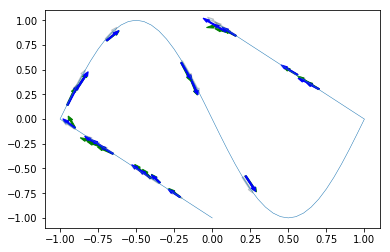

In [5]:
#lets predict the displacement
pred_y_mean_GP, pred_y_var_GP = mGP.predict_f(testing_x)
pred_y_mean_nnGP, pred_y_var_nnGP = mNNGP.predict_f(testing_x)

print(pred_y_mean_GP.shape, pred_y_var_GP.shape)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(full_sect[:, 0], full_sect[:, 1], lw=0.5)
for i, ind in enumerate(testing_indices):
    ax.arrow(full_sect[ind, 0], full_sect[ind, 1], full_sect_dir[ind, 0], full_sect_dir[ind, 1], width=0.01, alpha=0.2)
    ax.arrow(testing_x[i, 0], testing_x[i, 1], pred_y_mean_GP[i, 0], pred_y_mean_GP[i, 1], width=0.01, color='g')
    ax.arrow(testing_x[i, 0], testing_x[i, 1], pred_y_mean_nnGP[i, 0], pred_y_mean_nnGP[i, 1], width=0.01, color='b')

print('test average loglikelihood (GP): ', np.mean(mGP.predict_density(testing_x, pred_y_mean_GP)))
print('test average loglikelihood (nn featured GP): ', np.mean(mNNGP.predict_density(testing_x, pred_y_mean_nnGP)))

print('test average cos similarity (GP): ', np.mean(np.diag(pred_y_mean_GP.dot(full_sect_dir[testing_indices].T))/(np.linalg.norm(pred_y_mean_GP, axis=-1)*np.linalg.norm(full_sect_dir[testing_indices], axis=-1))))
print('test average cos similarity (nn featured GP): ', np.mean(np.diag(pred_y_mean_nnGP.dot(full_sect_dir[testing_indices].T))/(np.linalg.norm(pred_y_mean_nnGP, axis=-1)*np.linalg.norm(full_sect_dir[testing_indices], axis=-1))))